# 초기설정

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
from numpy.lib.shape_base import tile
import pandas as pd
import os
from glob import glob
import shutil
import cv2
from tqdm.notebook import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix

base_dir = '/content/drive/MyDrive/skin_data/'

# ex) {'ISIC_0032711': '/content/drive/MyDrive/skin_data/HAM10000_images_part_2/ISIC_0032711.jpg'}
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


# 이미지 파일(.jpg) : 600x450
# path : 이미지 파일 경로, cell_type : 병명, cell_type_idx
tile_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get)
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes

tile_df.sample(30)
#tile_df[tile_df['path'].isna()]

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
1713,HAM_0002342,ISIC_0032925,mel,histo,40.0,male,back,/content/drive/MyDrive/skin_data/HAM10000_imag...,Melanoma,5
9998,HAM_0004282,ISIC_0033358,akiec,histo,65.0,female,face,/content/drive/MyDrive/skin_data/HAM10000_imag...,Actinic keratoses,0
6717,HAM_0000892,ISIC_0029845,nv,histo,40.0,male,trunk,/content/drive/MyDrive/skin_data/HAM10000_imag...,Melanocytic nevi,4
5173,HAM_0003492,ISIC_0029228,nv,follow_up,35.0,male,lower extremity,/content/drive/MyDrive/skin_data/HAM10000_imag...,Melanocytic nevi,4
2150,HAM_0004507,ISIC_0029958,mel,histo,65.0,female,face,/content/drive/MyDrive/skin_data/HAM10000_imag...,Melanoma,5
6146,HAM_0005934,ISIC_0031740,nv,follow_up,45.0,male,back,/content/drive/MyDrive/skin_data/HAM10000_imag...,Melanocytic nevi,4
4275,HAM_0002407,ISIC_0028731,nv,follow_up,75.0,female,lower extremity,/content/drive/MyDrive/skin_data/HAM10000_imag...,Melanocytic nevi,4
3711,HAM_0006659,ISIC_0028160,nv,follow_up,55.0,male,trunk,/content/drive/MyDrive/skin_data/HAM10000_imag...,Melanocytic nevi,4
3433,HAM_0005797,ISIC_0027220,nv,follow_up,60.0,male,abdomen,/content/drive/MyDrive/skin_data/HAM10000_imag...,Melanocytic nevi,4
5772,HAM_0001124,ISIC_0026587,nv,follow_up,50.0,female,abdomen,/content/drive/MyDrive/skin_data/HAM10000_imag...,Melanocytic nevi,4


In [ ]:
df = pd.DataFrame()

df['filepaths'] = tile_df['path']
df['labels'] = tile_df['cell_type_idx']
df['labels'] = df['labels'].apply(lambda x: str(x))
print(len(df))
df.head()

10015


,filepaths,labels
0,/content/drive/MyDrive/skin_data/HAM10000_imag...,2
1,/content/drive/MyDrive/skin_data/HAM10000_imag...,2
2,/content/drive/MyDrive/skin_data/HAM10000_imag...,2
3,/content/drive/MyDrive/skin_data/HAM10000_imag...,2
4,/content/drive/MyDrive/skin_data/HAM10000_imag...,2


In [ ]:
# for Fairness Evaluation
df2 = pd.DataFrame()

df2['filepath'] = tile_df['path']
df2['labels'] = tile_df['cell_type_idx']
df2['labels'] = df['labels'].apply(lambda x: str(x))
df2['age'] = tile_df['age']
df2['sex'] = tile_df['sex']
df2.head()

,filepath,labels,age,sex
0,/content/drive/MyDrive/skin_data/HAM10000_imag...,2,80.0,male
1,/content/drive/MyDrive/skin_data/HAM10000_imag...,2,80.0,male
2,/content/drive/MyDrive/skin_data/HAM10000_imag...,2,80.0,male
3,/content/drive/MyDrive/skin_data/HAM10000_imag...,2,80.0,male
4,/content/drive/MyDrive/skin_data/HAM10000_imag...,2,75.0,male


In [ ]:
df.labels.unique()

array(['2', '4', '3', '5', '6', '1', '0'], dtype=object)

# Split(df1)

In [ ]:
def split_df(df, trsize, column):
  train_df, dummy_df = train_test_split(df, train_size=trsize, random_state=42, stratify=df[column])
  valid_df, test_df = train_test_split(dummy_df, train_size=trsize, random_state=42, stratify=dummy_df[column])
  return train_df, valid_df, test_df

train_df, valid_df, test_df = split_df(df, 0.8, 'labels')


print(f"split 이후 train data --> length : {len(train_df)}, class_count : {len(train_df['labels'].unique())}")
print(f"split 이후 train data 의 class 별 data 개수 --> \n {train_df['labels'].value_counts()}")

split 이후 train data --> length : 8012, class_count : 7
split 이후 train data 의 class 별 data 개수 --> 
 4    5364
5     890
2     879
1     411
0     262
6     114
3      92
Name: labels, dtype: int64


# Split(df2)

In [ ]:
train_df2, valid_df2, test_df2 = split_df(df2, 0.8, 'labels')

# Trim(데이터 균형)

In [ ]:
def trim(df, max_samples, min_samples, column):
  df = df.copy()
  classes = df[column].unique()
  class_count = len(classes)
  length = len(df)

  print(f'Classes -> {classes}')
  print(f'Before trim -> length : {length}, class_count : {class_count}')

  groups = df.groupby(column)
  trimmed_df = pd.DataFrame(columns = df.columns)
  groups = df.groupby(column)

  for label in df[column].unique():
    group = groups.get_group(label)
    count = len(group)

    if count > max_samples:
      sampled_group = group.sample(n=max_samples, random_state=123, axis=0)
      trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)

    else:
      if count >= min_samples:
        sampled_group = group
        trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)

  print(f'After trim -> sample max : {max_samples}, sample min : {min_samples}')

  classes = trimmed_df[column].unique()
  class_count = len(classes)
  length = len(trimmed_df)

  print(f'After trim -> length : {length}, class_count : {class_count}')

  return trimmed_df, classes, class_count

max_samples, min_samples = 1000, 0
column = 'labels'

train_df, classes, class_count = trim(train_df, max_samples, min_samples, column)
print(f'trim 이후 train data 길이 --> {len(train_df)}')
print(f"\ntrim 이후 train data 의 class 별 data 개수 --> \n {train_df['labels'].value_counts()}")

Classes -> ['4' '2' '5' '3' '1' '0' '6']
Before trim -> length : 8012, class_count : 7
After trim -> sample max : 1000, sample min : 0
After trim -> length : 3648, class_count : 7
trim 이후 train data 길이 --> 3648

trim 이후 train data 의 class 별 data 개수 --> 
 4    1000
5     890
2     879
1     411
0     262
6     114
3      92
Name: labels, dtype: int64


# Balance(데이터 증강)

In [ ]:
def balance(df, n,column, working_dir, img_size):

    def get_augmented_image(image):
        width = int(image.shape[1] * 0.8)
        height = int(image.shape[0] * 0.8)
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=30, p=0.25),
            A.RandomBrightnessContrast(p=0.5),
            A.RandomGamma(p=0.5),
            A.RandomCrop(width=width, height=height, p=0.25)
            ])

        return transform(image=image)['image']

    def dummy(image):
        return image


    df=df.copy()
    print(f'처음 df 길이 --> {len(df)}')

    aug_dir = os.path.join(working_dir, 'aug') # 증강된 이미지가 저장될 주소

    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)

    os.mkdir(aug_dir)

    for label in df[column].unique():
        dir_path = os.path.join(aug_dir, label) # label 별로 저장하기 위함
        os.mkdir(dir_path)

    total = 0
    groups = df.groupby(column) # group by class

    for label in df[column].unique(): # Class 별로 수행
        group = groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count = len(group)   # determine how many samples there are in this class

        if sample_count < n: # if the class has less than target number of images
            aug_img_count = 0
            delta = n - sample_count  # number of augmented images to create
            target_dir = os.path.join(aug_dir, label)  # define where to write the images
            desc = f'augmenting class {label}'

            for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
                j = i % sample_count
                img_path = group['filepaths'].iloc[j]
                img = cv2.imread(img_path)
                img = get_augmented_image(img)
                fname = os.path.basename(img_path)
                fname = 'aug' + str(i) + '-' + fname
                dest_path = os.path.join(target_dir, fname)
                cv2.imwrite(dest_path, img) # 이미지 저장
                aug_img_count += 1

            total += aug_img_count

    print(f'이미지 증강 수 --> {total}')

    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths = []
    aug_labels = []
    classlist = sorted(os.listdir(aug_dir))

    for klass in classlist:
        classpath = os.path.join(aug_dir, klass)
        flist = sorted(os.listdir(classpath))

        for f in flist:
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)

    Fseries = pd.Series(aug_fpaths, name='filepaths')
    Lseries = pd.Series(aug_labels, name='labels')
    aug_df = pd.concat([Fseries, Lseries], axis=1)
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)

    print(f'증강된 df 길이 --> {len(df)}')
    return df

n = 1000
working_dir = r'/content/drive/MyDrive/'
img_size = (310, 640)
column = 'labels'

train_df = balance(train_df, n, column, working_dir, img_size)
print(f"\n balance 이후 train data 의 class 별 data 개수 --> \n {train_df['labels'].value_counts()}")

처음 df 길이 --> 3648


augmenting class 2:   0%|                                                                    | 0/121 [00:00<?,…

augmenting class 5:   0%|                                                                    | 0/110 [00:00<?,…

augmenting class 3:   0%|                                                                    | 0/908 [00:00<?,…

augmenting class 1:   0%|                                                                    | 0/589 [00:00<?,…

augmenting class 0:   0%|                                                                    | 0/738 [00:00<?,…

augmenting class 6:   0%|                                                                    | 0/886 [00:00<?,…

이미지 증강 수 --> 3352
증강된 df 길이 --> 7000

 balance 이후 train data 의 class 별 data 개수 --> 
 4    1000
2    1000
5    1000
3    1000
1    1000
0    1000
6    1000
Name: labels, dtype: int64


In [ ]:
train_df

,filepaths,labels
0,/content/drive/MyDrive/skin_data/HAM10000_imag...,4
1,/content/drive/MyDrive/skin_data/HAM10000_imag...,4
2,/content/drive/MyDrive/skin_data/HAM10000_imag...,4
3,/content/drive/MyDrive/skin_data/HAM10000_imag...,4
4,/content/drive/MyDrive/skin_data/HAM10000_imag...,4
...,...,...
6995,/content/drive/MyDrive/aug/6/aug95-ISIC_003121...,6
6996,/content/drive/MyDrive/aug/6/aug96-ISIC_003399...,6
6997,/content/drive/MyDrive/aug/6/aug97-ISIC_002587...,6
6998,/content/drive/MyDrive/aug/6/aug98-ISIC_002871...,6


# Generator 생성

In [ ]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
   trgen = ImageDataGenerator(horizontal_flip=True)
   t_and_v_gen = ImageDataGenerator()
   msg = '{0:70s} for train generator'.format(' ')

   print(msg, '\r', end='')

   # Train Generator
   train_gen = trgen.flow_from_dataframe(
      train_df, x_col='filepaths',
      y_col=ycol, target_size=img_size,
      class_mode='categorical',
      color_mode='rgb',
      shuffle=True,
      batch_size=batch_size)

   print(msg, '\r', end='')

   # Valid Generator
   valid_gen = t_and_v_gen.flow_from_dataframe(
      valid_df, x_col='filepaths',
      y_col=ycol, target_size=img_size,
      class_mode='categorical',
      color_mode='rgb',
      shuffle=False,
      batch_size=batch_size
   )

   length = len(test_df)
   test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
   test_steps = int(length/test_batch_size)

   msg = '{0:70s} for test generator'.format(' ')

   print(msg, '\r', end='')

   # Test Generator
   test_gen = t_and_v_gen.flow_from_dataframe(
      test_df, x_col='filepaths',
      y_col=ycol, target_size=img_size,
      class_mode='categorical',
      color_mode='rgb',
      shuffle=False,
      batch_size=test_batch_size
   )

   classes = list(train_gen.class_indices.keys())
   class_indices = list(train_gen.class_indices.values())
   class_count = len(classes)
   labels = test_gen.labels
   print(f'test batch size : {test_batch_size}, test steps : {test_steps}, number of classes : {class_count}')

   return train_gen, test_gen, valid_gen, test_steps

bs = 16
ycol = 'labels'
train_gen, test_gen, valid_gen, test_steps = make_gens(bs, ycol, train_df, test_df, valid_df, img_size)

Found 7000 validated image filenames belonging to 7 classes.
Found 1602 validated image filenames belonging to 7 classes.
Found 401 validated image filenames belonging to 7 classes.
test batch size : 1, test steps : 401, number of classes : 7


In [ ]:
def F1_score(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
  return f1_val

# Model 생성 및 훈련

In [ ]:
def make_model(img_size, lr, mod_num=3):
  img_shape = (img_size[0], img_size[1], 3)

  if mod_num == 0:
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
    )

  elif mod_num == 3:
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(
        include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
    )

  elif mod_num == 5:
    base_model = tf.keras.applications.efficientnet.EfficientNetB5(
        include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
    )

  else:
    base_model = tf.keras.applications.efficientnet.EfficientNetB7(
        include_top=False, weigths="imagenet", input_shape=img_shape, pooling='max'
    )

  base_model.trainable = True

  x = base_model.output
  x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
  x = Dense(
            256,
            kernel_regularizer=regularizers.l2(l=0.016),
            activity_regularizer=regularizers.l1(0.006),
            bias_regularizer=regularizers.l1(0.006),
            activation='relu'
            )(x)

  x = Dropout(rate=0.4, seed=123)(x)
  output = Dense(class_count, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=output)

  model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC'])
  return model


lr = 0.001
model = make_model(img_size, lr)

43941136/43941136 [==============================] - 2s 0us/step


In [ ]:
epochs = 40

model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, validation_steps=None, shuffle=False, initial_epoch=0)

Epoch 1/40
438/438 [==============================] - 976s 2s/step - loss: 6.8604 - accuracy: 0.6381 - F1_score: 0.6144 - auc: 0.9096 - val_loss: 5.2976 - val_accuracy: 0.6536 - val_F1_score: 0.6589 - val_auc: 0.9450
Epoch 2/40
438/438 [==============================] - 176s 402ms/step - loss: 3.6457 - accuracy: 0.8117 - F1_score: 0.7987 - auc: 0.9757 - val_loss: 2.7729 - val_accuracy: 0.7903 - val_F1_score: 0.7674 - val_auc: 0.9712
Epoch 3/40
438/438 [==============================] - 175s 400ms/step - loss: 1.9813 - accuracy: 0.8744 - F1_score: 0.8652 - auc: 0.9872 - val_loss: 1.6073 - val_accuracy: 0.8059 - val_F1_score: 0.7966 - val_auc: 0.9788
Epoch 4/40
438/438 [==============================] - 175s 399ms/step - loss: 1.1637 - accuracy: 0.9031 - F1_score: 0.8934 - auc: 0.9912 - val_loss: 1.2546 - val_accuracy: 0.7809 - val_F1_score: 0.7730 - val_auc: 0.9694
Epoch 5/40
438/438 [==============================] - 174s 397ms/step - loss: 0.7502 - accuracy: 0.9263 - F1_score: 0.9205 

In [ ]:
# 모델 저장

model.save('/content/drive/MyDrive')
print('모델 저장 완료!')

모델 저장 완료!


# Plot

In [ ]:
def tr_plot(tr_data):
  start_epochs = 0

  tacc = tr_data.history['accuracy']
  tlose = tr_data.history['lose']
  vacc = tr_data.history['val_accuracy']
  vloss = tr_data.history['val_loss']
  tf1 = tr_data.history['F1_Score']
  vf1 = tr_data.history['val_F1_score']
  tauc = tr_data.history['auc']
  vauc = tr_data.history['val_auc']
  epoch_count = len(tacc) + start_epochs
  epochs = []

  for i in range(start_epochs, epoch_counts):
    epochs.append(i+1)

  index_loss = np.argmin(vloss)
  val_lowest = vloss[index_loss]
  index_acc = np.argmax(vacc)
  acc_highest = vacc[index_acc]
  auc_index = np.argmax(vauc)
  val_highst_auc = vauc[auc_index]
  plt.style.use('fivethirtyeight')

  sc_label = f'best epochs = {str(index_loss + 1 + start_epochs)}'
  vc_label = f'best epochs = {str(index_acc + 1 + start_epochs)}'
  auc_label = f'best epochs = {str(auc_index) + 1 + start_epochs)}'
  fig.axes = plt.subplots(nrows=1, ncols=4, figsize=(25,10))
  axes[0].plot(Epochs,tloss, 'r', label='Training loss')
  axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
  axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
  axes[0].scatter(Epochs, tloss, s=100, c='red')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs', fontsize=18)
  axes[0].set_ylabel('Loss', fontsize=18)
  axes[0].legend()

  axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
  axes[1].scatter(Epochs, tacc, s=100, c='red')
  axes[1].plot (Epochs, vacc, 'g', label='Validation Accuracy')
  axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
  axes[1].set_title('Training and Validation Accuracy')
  axes[1].set_xlabel('Epochs', fontsize=18)
  axes[1].set_ylabel('Accuracy', fontsize=18)
  axes[1].legend()

  axes[2].plot(Epochs, tf1, 'r', label='Training F1 score')
  axes[2].plot(Epochs, vf1, 'g', label='Validation F1 score')
  index_tf1 = np.argmax(tf1)#  this is the epoch with the highest training F1 score
  tf1max = tf1[index_tf1]
  index_vf1 = np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
  vf1max = vf1[index_vf1]
  axes[2].scatter(index_vf1 + 1 + start_epoch, vf1max, s=150, c='blue', label=vc_label)
  axes[2].scatter(Epochs, tf1, s=100, c='red')
  axes[2].set_title('Training and Validation F1 score')
  axes[2].set_xlabel('Epochs', fontsize=18)
  axes[2].set_ylabel('F1 score', fontsize=18)
  axes[2].legend()
  axes[3].plot(Epochs, tauc, 'r', label='Training AUC')
  axes[3].plot(Epochs, vauc,'g', label='Validation AUC' )
  axes[3].scatter(auc_index + 1 + start_epoch, val_highest_auc, s=150, c= 'blue', label=sc_label)
  axes[3].scatter(Epochs, tauc, s=100, c='red')
  axes[3].set_title('Training and Validation AUC')
  axes[3].set_xlabel('Epochs', fontsize=18)
  axes[3].set_ylabel('AUC', fontsize=18)
  axes[3].legend()
  plt.tight_layout
  plt.show()
  return

tr_plot(history)

SyntaxError: ignored

#(예정) Evaluation(Confusion Matrix -> accuracy, precision, recall, F1-Score)

401/401 [==============================] - 7s 17ms/step


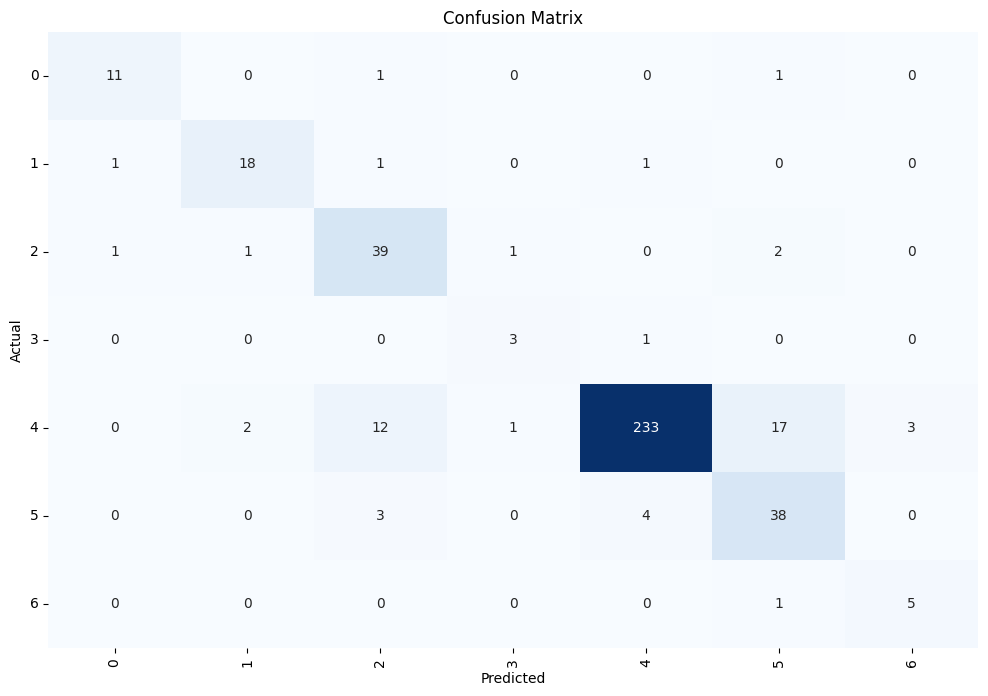

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.8462    0.8462    0.8462        13
           1     0.8571    0.8571    0.8571        21
           2     0.6964    0.8864    0.7800        44
           3     0.6000    0.7500    0.6667         4
           4     0.9749    0.8694    0.9191       268
           5     0.6441    0.8444    0.7308        45
           6     0.6250    0.8333    0.7143         6

    accuracy                         0.8653       401
   macro avg     0.7491    0.8410    0.7877       401
weighted avg     0.8879    0.8653    0.8715       401



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def predictor(test_gen):
    y_pred = []
    error_list = []
    error_pred_list = []
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)

    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors += 1
            file = test_gen.filenames[i]
            error_list.append(file)
            error_class = classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)

    acc= ( 1-errors/tests ) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)

    f1score = f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <= 30:
        cm = confusion_matrix(ytrue, ypred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score, y_pred, y_true

errors, tests, error_list, error_pred_list, f1score, y_pred, y_true = predictor(test_gen)

In [ ]:
# 모델 저장

model.save('/content/drive/MyDrive/efficientnet.h5')
print('모델 저장 완료!')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


모델 저장 완료!


In [ ]:
import cv2
import numpy as np
import tensorflow
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import backend as K
import numpy as np

def F1_score(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
  return f1_val

tf.keras.utils.get_custom_objects()['F1_score'] = F1_score

loaded_model = load_model("/content/drive/MyDrive/efficientnet.h5")

image_path = '/content/drive/MyDrive/aug/6/aug0-ISIC_0026336.jpg'

img_size = (224, 224)
img = image.load_img(image_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


result = model.predict(img_array)

print(result.astype(float))

# top-1
class_index = np.argmax(result)

print("Predicted class index:", class_index)

1/1 [==============================] - 0s 36ms/step
[[7.84766235e-05 1.35920418e-04 2.20677219e-04 1.44202873e-04
  2.32578212e-04 2.19093781e-04 9.98969078e-01]]
Predicted class index: 6
